Rabi oscillations for the Jaynes Cummings model$$.

Este proyecto es presentado por Santiago Olave Escobar, de Cali-Colombia, estudiante de la Universidad del Valle para la Hackaton realizada por QColombia. La libreria implementada es QuTIP. El proyecto toma el modelo de Jaynes-Cummings para una interacción entre un campo electromagentico cuantizado y un atomo que se considera como un sistema de dos estados (excitado y base). Basicamente la interacción entre el atomo (que también puede considerarse un qubit dentro de una cavidad resonante) y el campo se fundamenta en la absorción y emisión de fotones. El sistema se toma en la aproximación RWA (rotating wave approximation) y supone que la frecuencia del campo $\omega$ y la diferencia de energía entre los estados excitados y base del atomo ($w_0$) son iguales($w=w_0$). Se busca llegar a las bien conocidas oscilaciones de Rabi para este modelo, en las cuales se observa el fenómeno de Colapso-Resurgimiento, las cuales permiten observar la dinamica del sistema. Se sugiere al evaluador probar con diferentes cantidades de fotones (n_max) para observar como el efecto de Colapso-Resurgimiento es mas notorio.

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

We first create the basis that will be use in this Jaynes-Cummings Model. In this case, the basis will be given by Fock's states and the orthonormal basis formed by the ground and excited state of the two states sustem (Qubic or atom).
The hamiltonian of this system (for $w_0=w=0$) is:
$$\hat{H}=\frac{1}{2}ħw_0\hat{\sigma_3}+ħw\hat{a}^†\hat{a}+ħλ(\hat{σ}_+\hat{a}+\hat{\sigma}_-\hat{a}^†)$$
Now, with this in mind, let´s start searching into the QuTIP functions to generate this hamiltonian.

$1$) The first thing we want to understand is how are states created in this library, so:

In [2]:
q = Qobj([[1], [0]])
q

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

2)In our case, the basis have a tensorial product of the two basis (Fock, and two level system). So, ¿how do we create a basis?

In [3]:
#Creamos la base de Fock (operador número) para un número maximo de "n" (fotones en el caso de este modelo) llamado n_max.
#Tamboén definimos la base del sistema de dos estados (ground and excited) y generamos el producto tensorial entre estas dos
#lo cual nos genera la base final "B", en la cual B[0-4] representa al ket |n,e> y B[5-9] representa al ket |n,g>.
def N(n_max): 
    FB=[]
    B=[]
    e=Qobj([[1],[0]])
    g=Qobj([[0],[1]])
    TLS=[e,g]
    for i in range(n_max):
        FB.append(basis(n_max,i))
        j=0
        for j in range(2):
            B.append(tensor(FB[i],TLS[j]))
    return B

Now we need to create the opeators that appear in our Hamiltonian, so

1) We have to think that some operators will act in just Fock states, and some others will act on the basis of  the two states system, so is nedeed to define also the tensorial product over operators (matrices):

1.1) Anihilation operator ($\hat{a}$):

In [4]:
destroy(5)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.         1.         0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.        ]
 [0.         0.         0.         1.73205081 0.        ]
 [0.         0.         0.         0.         2.        ]
 [0.         0.         0.         0.         0.        ]]

1.2)Creation Operator ($\hat{a}^{†}$):

In [5]:
create(5)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.         0.        ]
 [0.         0.         1.73205081 0.         0.        ]
 [0.         0.         0.         2.         0.        ]]

1.3)The QuTIP library already have the Pauli matrices given by: 

In [6]:
sigmaz()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [53]:
destroy(2)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

And now we define the tensorial product, $⊗$, in such way that we can decide what basis will the operator act on.
If we want to the $\sigma_z$ operator just act on the two level system then the correct product is $\textbf{1}⊗\sigma_z$, since in the definition of the basis we give certain order to the tensorial product (first {|n>} and then {|e>,|g>}).

In [55]:
def sm(n_max):
    sigma_m=tensor(qeye(n_max),destroy(2))
    return sigma_m
    
def sigma_z(n_max):
    sigma_z=tensor(qeye(n_max),sigmaz())
    return sigma_z

def a(n_max):
    anihilation=tensor(destroy(N=n_max),qeye(2))
    return anihilation

Now, we have all the objects require to create the hamiltonian of the system such that

In [46]:
def Hamiltonian(n_max):
    H=0.5*sigma_z(n_max) + a(n_max).dag()*a(n_max) + (  sm(n_max).dag()*a(n_max)  +  sm(n_max)*a(n_max).dag()  )
    return H

Now, we are going to try a simple example: Given the initial condition |n>=|50> and the atom-Qubit in the exciyed state |e>, then show the inversion of the system-(Inversion: The difference between the probability of find the two level system in the excited state and the ground state)

In [29]:
S_0=tensor(basis(50,49),basis(2,0))

Now, QuTIC also have a code that allow us to see how the system evolve in time with some initial condition (mesolve). The sintaxis of this code can be seen in https://qutip.org/docs/latest/apidoc/functions.html, but basically the module provides solvers for the Lindblad master equation and von Neumann equation, taking the Hamiltonian and initial state of the system, and gave us the expected value of an operator (e_ops).

In [91]:
result= mesolve(Hamiltonian(50), S_0, np.linspace(0,10,1000), e_ops=sigma_z(50))

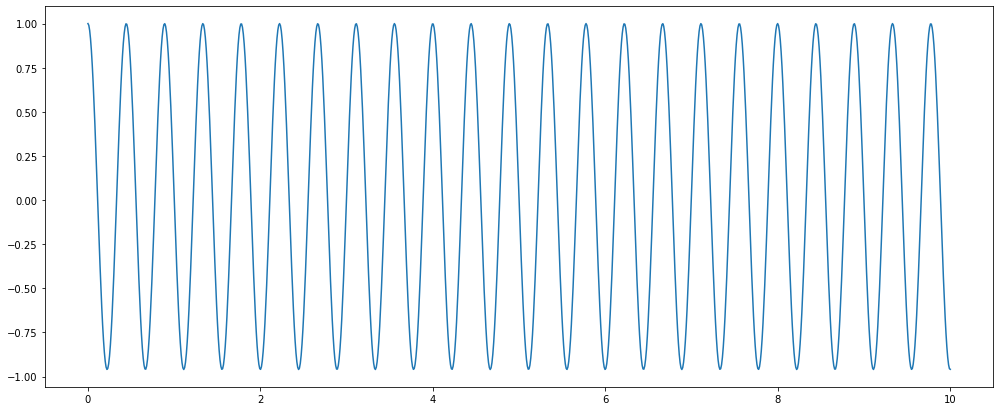

In [92]:
Pe=result.expect[0]
plt.figure(figsize=(17,7))
plt.plot(np.linspace(0,10,1000),Pe)

Now, what we can do, is compact all this function in just one, that allow us to generate the atomic inversion for a system in a given intial state

In [109]:
#We dfine a function call "system" that will print the Rabi oscillations (inversion of the system) for a initial state |n,e>, which means that the field
# or the resonance cavity has a quantity n of photons with a probability of 100%, and that the Atom-Qubit is with 100% certainty in the excited state. 
def system(n_max,n,init):
    print("Final time:")
    T_f=int(input())
    total=T_f*100
    sigma_z=tensor(qeye(n_max),sigmaz())
    if init==1:
        S_0=tensor(basis(n_max,n),basis(2,0))
        result= mesolve(Hamiltonian(n_max), S_0, np.linspace(0,T_f,total), e_ops=sigma_z)
        Pe=result.expect[0]
        plt.figure(figsize=(17,7))
        plt.plot(np.linspace(0,T_f,total),Pe)
    else:
        S_0=tensor(basis(n_max,n),basis(2,1))
        result= mesolve(Hamiltonian(n_max), S_0, np.linspace(0,T_f,total), e_ops=sigma_z)
        Pe=result.expect[0]
        plt.figure(figsize=(17,7))
        plt.plot(np.linspace(0,T_f,total),Pe)

Final time:


 10


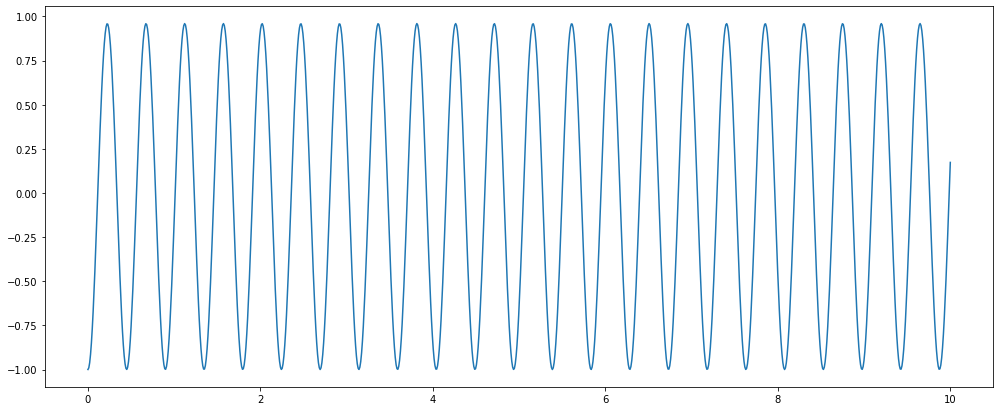

In [106]:
system(50,47,0)

Now, we can generalize the code to an arbitrary initial condition of the two level system and the field, to finally get to a field given by a coherent state.

First, let's generalize our previous system and get to an arbitrary contidion for the two level system; this is, a superposition of |e> and |g>, especifying the initial probability of find the system in the initial state |e>

In [111]:
#Then we include a variable Pe wich allow us to define the probability of have the atom-Qubit in the excited state (values in the interval [0,100]).
def system_2(n_max,n,Pe):
    P_e=np.sqrt(Pe/100)
    Pg=1-Pe/100
    P_g=np.sqrt(Pg)
    q = Qobj([[P_e], [P_g]])
    print("Final time:")
    T_f=int(input())
    total=T_f*100
    sigma_z=tensor(qeye(n_max),sigmaz())
    S_0=tensor(basis(n_max,n),q)
    result= mesolve(Hamiltonian(n_max), S_0, np.linspace(0,T_f,total), e_ops=sigma_z)
    Inv=result.expect[0]
    plt.figure(figsize=(17,7))
    plt.plot(np.linspace(0,T_f,total),Inv)

Final time:


 10


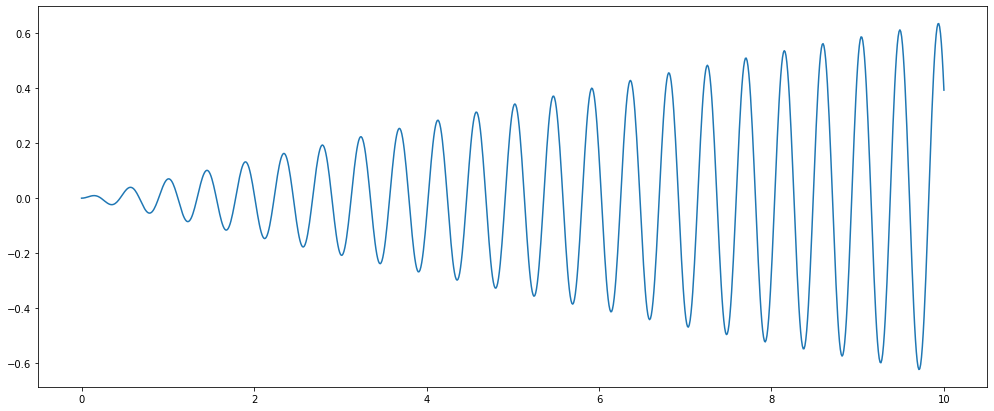

In [114]:
system_2(50,48,50)

Now, the superposition of Fock states for the quantized field will have probilty amplitudes given by a Poisson distrubution. Then, the initial state of the system will be a tensor product of the coherent state and the state of the two level system.

In [120]:
def system_3(n_max,alpha,Pe):
    P_e=np.sqrt(Pe/100)
    Pg=1-Pe/100
    P_g=np.sqrt(Pg)
    q = Qobj([[P_g], [P_e]])
    print("Final time:")
    T_f=int(input())
    total=T_f*100
    sigma_z=tensor(qeye(n_max),sigmaz())
    S_0=tensor(coherent(n_max,alpha),q)
    result= mesolve(Hamiltonian(n_max), S_0, np.linspace(0,T_f,total), e_ops=sigma_z)
    Inv=result.expect[0]
    plt.figure(figsize=(17,7))
    plt.plot(np.linspace(0,T_f,total),Inv)

The function "system_3" will show us the well-known Rabi Oscillations and the effect of collapse and revival of the Atomic Inversion.

In [ ]:
system_3(1000,100,1)

Final time:


 100000
